# ScaleSpikeSlab (S^3)

This scripts contain algorithms in Python for Scalable Spike-and-Slab (S^3), a scalable Gibbs sampling implementation for high-dimensional Bayesian regression with the continuous spike-and-slab prior.

It is based on the article "Scalable Spike-and-Slab", by Niloy Biswas, Lester Mackey and Xiao-Li Meng.

## A tutorial with GWAS data

### Importing packages

#### Importing colab functions (for Google Colab users)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
cd 'gdrive/My Drive/Niloy_Files/github/ScaleSpikeSlab/Python'

/content/gdrive/My Drive/Niloy_Files/github/ScaleSpikeSlab/Python


#### Importing ScalaSpikeSlab functions

In [3]:
from mcmc_functions import *
from helper_functions import *

### A tutorial with GWAS data

#### Import data and select hyperparameters.

In [4]:
# Riboflavin linear regression dataset of Buhlmann et al. (2014)
import pandas as pd
riboflavin = pd.read_csv('riboflavin.csv')
y = riboflavin['y'].to_numpy()
X = riboflavin.drop(['y','Unnamed: 0'], axis=1).to_numpy()

# # Synthetic data
# sync_data = synthetic_data(n=100, p=1000, s0=5, error_std=2, type='linear')
# X = sync_data['X']
# y = sync_data['y']

# # Select hyperparameters
hyperparams = spike_slab_params(n=X.shape[0],p=X.shape[1])

#### Run MCMC with S^3

In [6]:
# import multiprocess as mp

# chain_length=5000
# burnin=1000
# no_chains=20

# def f(x):
#     chain_output = spike_slab_linear(chain_length=chain_length, X=X, y=y, 
#                                      rinit=None, verbose=False, 
#                                      burnin=burnin, store=False, **hyperparams)
#     return chain_output['z_ergodic_avg']

# with mp.Pool(20) as pool:
#     z_averages = pool.map(f, range(no_chains))

In [7]:
# We use ray for parallel computation

# Install ray 
# !pip install ray

# import ray
# ray.shutdown()
# ray.init()

import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total

In [8]:
chain_length=5000
burnin=1000
no_chains=50

# Define the function you want to apply map on, as remote function. 
@ray.remote
def f(x):
    chain_output = spike_slab_linear(chain_length=chain_length, X=X, y=y, 
                                     rinit=None, verbose=False, 
                                     burnin=burnin, store=False, **hyperparams)
    return chain_output['z_ergodic_avg']

# Define a helper parmap(f, list) function.
# This function executes a copy of f() on each element in "list".
# Each copy of f() runs in a different process.
# Note f.remote(x) returns a future of its result (i.e., 
# an identifier of the result) rather than the result itself.  
def parmap(f, list):
    return [f.remote(x) for x in list]

# Call parmap() to run function f in parallel.
# NOTE: takes ~5mins to run.
result_ids = parmap(f, range(no_chains))

# Get the results
z_averages = ray.get(result_ids)

#### Plot Spike-and-Slab marginal posterior probabilities for variable selection

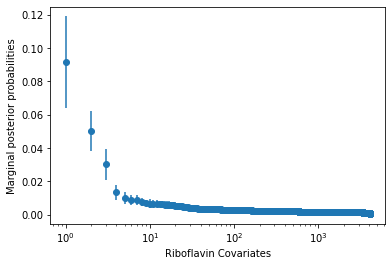

In [10]:
import numpy as np
import matplotlib.pyplot as plt


sorted_indices = np.argsort(np.mean(z_averages, axis=0))[::-1]
z_means = np.mean(z_averages, axis=0)[sorted_indices]
z_sds = (np.var(z_averages, axis=0)[sorted_indices]/no_chains)**0.5

plt.errorbar(x=np.arange(len(z_means))+1, y=z_means, yerr=3*z_sds,fmt='o')
plt.xscale('log')
plt.xlabel('Riboflavin Covariates')
plt.ylabel('Marginal posterior probabilities')
plt.show()